In [7]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, LineString
import descartes
import csv
import pandas as pd

with open('nodos.csv') as f:
    nodos = pd.read_csv(f)

barrios = nodos.NOMBRE[nodos.NOMBRE.duplicated()==False].values
    
DEFAULT_COLOR = {
  1:  '#8dd3c7',
  2:  '#ffffb3',
  3:  '#bebada',
  4:  '#fb8072',
  5:  '#80b1d3',
  6:  '#fdb462',
  7:  '#b3de69',
  8:  '#fccde5',
  9:  '#d9d9d9',
  10: '#bc80bd',
  11: '#ccebc5',
  12: '#ffed6f',
  13: '#b2df8a',
}

DEFAULT_BARRIOS = nodos.NOMBRE[nodos.NOMBRE.duplicated()==False].values

vecinos = {}

DEFAULT_COORDINATES  = {}

for barrio in DEFAULT_BARRIOS:
    nodos_barrio = nodos[nodos.NOMBRE==barrio]
    coordinates_barrio = zip(nodos_barrio.X.values, nodos_barrio.Y.values)
    poligon = Polygon(coordinates_barrio)
    
    DEFAULT_COORDINATES[barrio] = coordinates_barrio


def fitness(gen):
    """Returns a positive number that indicates how close the individual is to our desired solution.
    """    
    gendf = pd.DataFrame(gen)
    mad = gendf.mad()
    
    return mad.std()




# Ver Fitness.ipynb
def visualize(gen, color=DEFAULT_COLOR, barrios=DEFAULT_BARRIOS, coordinates=DEFAULT_COORDINATES, alpha=0.5):
    """Plots a solution for visual interpretation
    """
    plt.rcParams['figure.figsize'] = (20.0, 10.0)

    fig = plt.figure()
    ax = fig.add_subplot(121)
    
    # vamos de gen a barrio, dia. Como se hace?
    # sacamos el barrio, dia de la matriz de gen.
    gis = zip(barrios, coordinates.values()) 
    
    rows, columns = gen.shape

    for row in range(rows):
        for column in range(columns):
            data = gen[row, column]

            if data > 0:
                poly = coordinates[sorted(barrios)[row]]     
                ax.add_patch(descartes.PolygonPatch(Polygon(poly), fc=color[column+1], alpha=alpha))
    
    ax.axis('equal')
    
    ax2 = fig.add_subplot(122)
    gendf = pd.DataFrame(gen)
    gendf.mad().plot.bar()

    plt.show()
    
# Ver MatrizVecinos.ipynb
matriz_vecinos = pd.read_csv('adyacencia.csv', sep=';', index_col=0)

with open('lectura.csv') as f:
    lectura = pd.read_csv(f)
    
DEFAULT_CLIENTES = dict(zip(lectura.GIS, lectura.Clientes))

# Ver Genetic.ipynb
from pyevolve import G2DList
from pyevolve import GSimpleGA
from pyevolve import Selectors
from pyevolve import Crossovers
from pyevolve import Mutators
from pyevolve import GAllele
from pyevolve import Consts

from random import shuffle, randint


def evaluation_function(chromosome):
    # We want to give higher score to those solutions that have small mad.
    chromosome_np = np.asarray([row for row in chromosome])
    chromosome_pd = pd.DataFrame(chromosome_np)
    mad = chromosome_pd.mad()
    error = mad.std()
    
    # We want to give higher score to those solutions
    # that have barrios that are closer to each other
    # Meaning that each barrio should have at least one neighbor in the same day:
    #for dia in chromosome_np.T:
    #    dia[dia!=0] = 1
    #    cercania = sum(matriz_vecinos.dot(dia)) - sum(dia)
    # return error + 1000 / cercania
    return error


def G2DListBarrioInitializator(genome, **args):
    """ The initializator for our problem """
    
    allele = genome.getParam("allele", None)
    
    if allele is None:
        Util.raiseException("to use the G2DListBarrioInitializator, you must specify the 'allele' parameter")

    genome.clearList()

    for i in xrange(genome.getHeight()):
        options = allele[i].options
        active = randint(0, genome.getWidth())
        for j in xrange(genome.getWidth()):
            value = 0
            
            if j == active:
                value = options[i]
                
            genome.setItem(i, j, value)
            
    #shuffle(genome.genomeList)

def G2DBarrioXSinglePoint(genome, **args):
    sister = None
    brother = None
    gMom = args["mom"]
    gDad = args["dad"]
    
    widthMom = gMom.getWidth()

    cut = randint(1, widthMom - 1)

    if args["count"] >= 1:
        sister = gMom.clone()
        sister.resetStats()
        invSister = np.array([row for row in sister]).T
        invSister[cut:] = np.array([row for row in gDad]).T[cut:]
        for i, row in enumerate(invSister.T):
            for j, item in enumerate(row):
                sister.setItem(i, j, item)
        
    if args["count"] == 2:
        brother = gDad.clone()
        brother.resetStats()
        invBrother = np.array([row for row in brother]).T
        invBrother[cut:] = np.array([row for row in gMom]).T[cut:]
        for i, row in enumerate(invBrother.T):
            for j, item in enumerate(row):
                brother.setItem(i, j, item)

    return (sister, brother)

def G2DBarrioMutatorSwap(genome, **args):

    if args["pmut"] <= 0.0:
        return 0
    stringLength = len(genome)
    mutations = args["pmut"] * (stringLength)

    if mutations < 1.0:
        mutations = 0
        for it in xrange(stringLength):
            if Util.randomFlipCoin(args["pmut"]):
                Util.listSwapElement(genome, it, randint(0, stringLength - 1))
                mutations += 1

    else:
        for it in xrange(int(round(mutations))):
            Util.listSwapElement(genome, randint(0, stringLength - 1),
                              randint(0, stringLength - 1))

    return int(mutations)    

def ga(dias=13, barrios=329, generations=100, freq_stats=10, clientes=DEFAULT_CLIENTES, evaluation=evaluation_function):
    # Genome instance
    genome = G2DList.G2DList(barrios, dias)
    
    # alleles are initialized from client list.
    
    alleles = GAllele.GAlleles()
    ordered_clientes = [clientes[key] for key in sorted(clientes)]
    for i, item in enumerate(ordered_clientes):
        zeros = np.zeros(len(clientes))
        zeros[i] = item
        
        a = GAllele.GAlleleList(zeros)
        alleles.add(a)
    
    genome.setParams(allele=alleles)
    
    # The evaluator function (objective function)
    genome.evaluator.set(evaluation)
    genome.crossover.set(G2DBarrioXSinglePoint)
    genome.mutator.set(G2DBarrioMutatorSwap)
    genome.initializator.set(G2DListBarrioInitializator)
    

    # Genetic Algorithm Instance
    ga = GSimpleGA.GSimpleGA(genome)
    ga.setGenerations(generations)
    ga.setMutationRate(0.0);
    ga.setMinimax(Consts.minimaxType["minimize"])
    ga.terminationCriteria.set(GSimpleGA.ConvergenceCriteria)

    # Do the evolution, with stats dump
    # frequency of 10 generations
    ga.evolve(freq_stats=freq_stats)
    return ga.bestIndividual()


def ga_to_array(solution):
    return np.asarray([row for row in solution], dtype=np.uint16)

In [8]:
# Cargar matriz de vecinos.

In [9]:
dias = dict(zip(lectura.GIS, lectura.Dia))

initial_solution = np.zeros((len(lectura.GIS), len(lectura.Dia.unique()+1)))


for index, barrio in enumerate(sorted(lectura.GIS)):
    initial_solution[index, dias[barrio]-1] = DEFAULT_CLIENTES[barrio]

## Antes de empezar a generar soluciones mejores que la inicial, grafiquemos el MAD y la ubicación espacial de esa solución

In [10]:
#visualize(initial_solution)

In [16]:
def g(generations):
    our_solution_ga = ga(generations=generations, freq_stats=generations/10)
    our_solution = ga_to_array(our_solution_ga)
    visualize(our_solution)
    #print pd.DataFrame(our_solution)

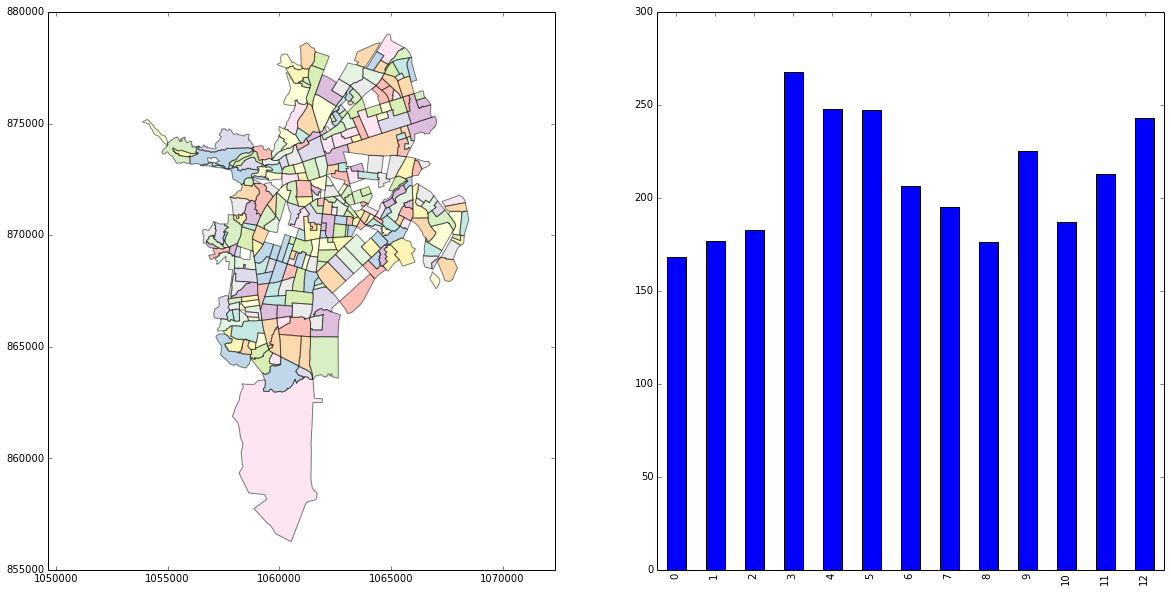

In [17]:
g(1)

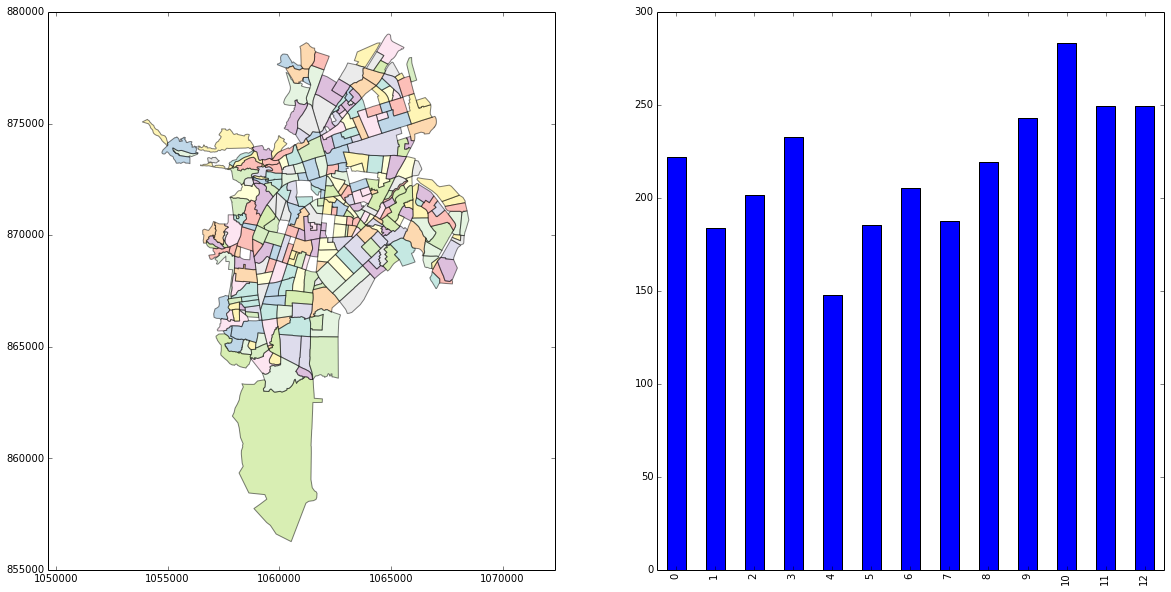

CPU times: user 2.87 s, sys: 63.9 ms, total: 2.94 s
Wall time: 3.13 s


In [18]:
%time g(1)

Gen. 0 (0.00%): Max/Min/Avg Fitness(Raw) [71.39(82.87)/46.59(34.14)/59.49(59.49)]
Gen. 1 (10.00%): Max/Min/Avg Fitness(Raw) [46.00(34.14)/46.00(34.14)/46.00(34.14)]

	Evolution stopped by Termination Criteria function !

Gen. 1 (10.00%): Max/Min/Avg Fitness(Raw) [46.00(34.14)/46.00(34.14)/46.00(34.14)]
Total time elapsed: 1.388 seconds.


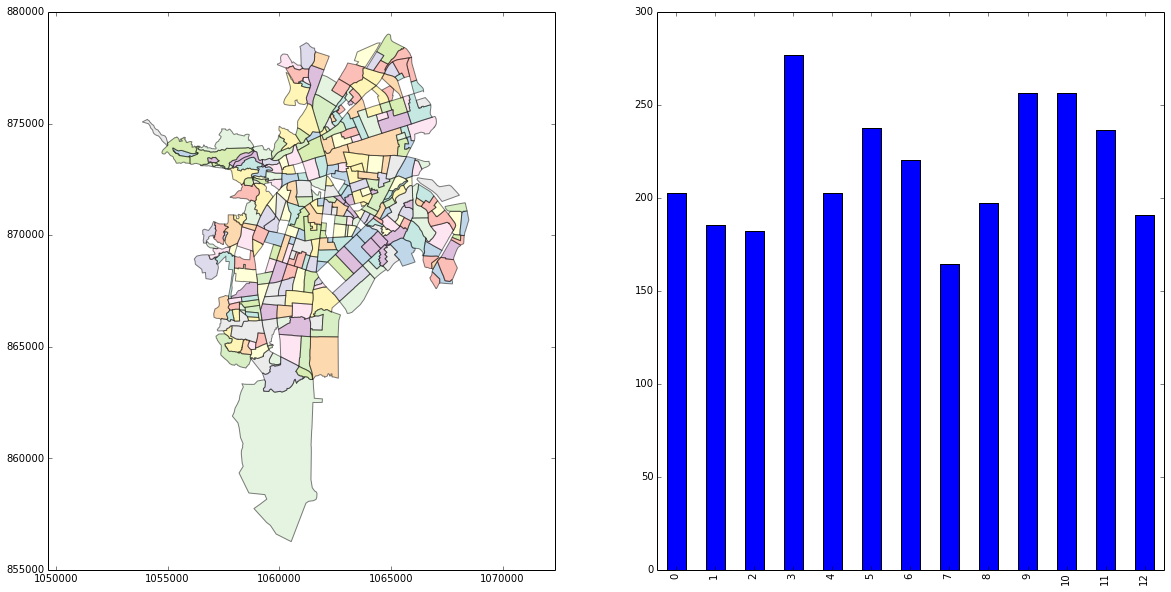

CPU times: user 3.33 s, sys: 106 ms, total: 3.43 s
Wall time: 3.8 s


In [19]:
%time g(10)

Gen. 0 (0.00%): Max/Min/Avg Fitness(Raw) [70.13(87.34)/47.92(32.42)/58.44(58.44)]

	Evolution stopped by Termination Criteria function !

Gen. 1 (0.10%): Max/Min/Avg Fitness(Raw) [40.00(32.42)/40.00(32.42)/40.00(32.42)]
Total time elapsed: 0.899 seconds.


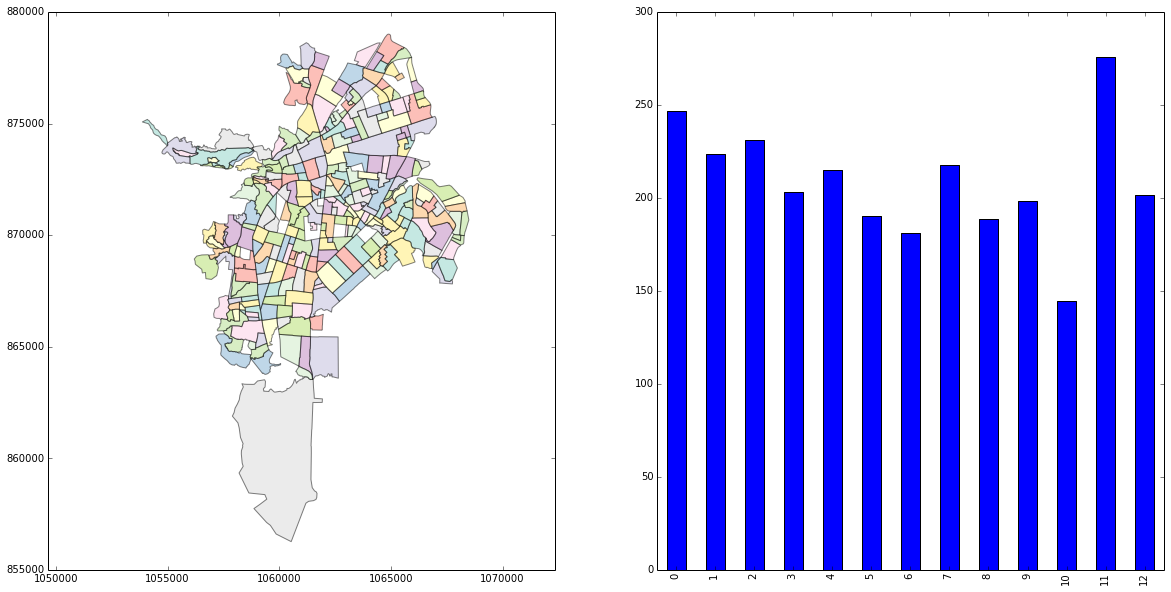

CPU times: user 2.47 s, sys: 26.6 ms, total: 2.49 s
Wall time: 2.5 s


In [20]:
%time g(1000)

In [21]:
visualize(our_solution)

NameError: name 'our_solution' is not defined

In [ ]:
import numpy as np
cercanos = np.array([[0, 1, 0, 1],
                     [1, 0, 0, 1],
                     [0, 0, 0, 0],
                     [1, 1, 0, 0]
                    ])

In [ ]:
opcion1 = np.array([1, 1, 0, 1])
opcion2 = np.array([1, 0, 1, 0])
opcion3 = np.array([0, 1, 0, 1])
opcion4 = np.array([1, 1, 1, 1])

In [ ]:
def evaluar(cercanos, opcion_input):
    opcion_in = pd.DataFrame(opcion_input)
    opcion_unos = opcion_in.where(opcion_in!=0) / opcion_in
    opcion = np.nan_to_num(opcion_unos)
    return sum(cercanos.dot(opcion)) - sum(opcion)

In [ ]:
evaluar(cercanos, opcion1), evaluar(cercanos, opcion2), evaluar(cercanos, opcion3), evaluar(cercanos, opcion4)

In [16]:
dia

NameError: name 'dia' is not defined

In [24]:
matriz_vecinos.T[2:5].T

,2,3,4
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
5,0,0,0
6,1,0,0
7,0,0,0
8,0,0,0
9,0,0,0


In [ ]:
row